In [ ]:
import importlib
import my_functions

# Reload the module to reflect changes
importlib.reload(my_functions)

# Re-import the functions to update them
from my_functions import *

In [2]:
#Import functions------------------------------------------------------------------------------------------------------
from my_functions import*
#Open Zmumu file
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") 
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

#Set event range
nmin1=0
nmax1=3000

#Choose quality 0
Zmumu_pt=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin1:nmax1]
Zmumu_eta=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin1:nmax1]
Zmumu_phi=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin1:nmax1]
#Select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi= get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

#Open ZeroBias file
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/zbV3_skim.root") 
MuonTree_ZeroBias=file["MuonTree;1"]

#Apply energy cut to offline
ZeroBias_pt=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())
ZeroBias_eta=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())
ZeroBias_phi=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())

#Get online data
Zbl1_pt=MuonTree_ZeroBias["LVL1Muon_et"].array() * 1000
Zbl1_eta=MuonTree_ZeroBias["LVL1Muon_eta"].array()
Zbl1_phi=MuonTree_ZeroBias["LVL1Muon_phi"].array()

#Create mask matching offline and LVL1
mask=offline_LVL1_matcher(ZeroBias_eta, ZeroBias_phi, Zbl1_eta, Zbl1_phi, dr_threshold=0.4)

#Apply mask
ZeroBias_pt=ZeroBias_pt[mask]
ZeroBias_eta=ZeroBias_eta[mask]
ZeroBias_phi=ZeroBias_phi[mask]

494957it [01:45, 4678.91it/s]


In [ ]:
l1=len(ak.flatten(Zmumu_pt))
l2=len(ak.flatten(ZeroBias_pt))

coolplot([Zmumu_pt/1000, ZeroBias_pt/1000], np.linspace(0,100, 40),
          labels=[rf"Signal muons, n={l1}", 
                  f"Background muons, n={l2}"], 
                  title="Muon $p_T$ histogram", x_label=r"$p_T$ [GeV]",
                    y_label="Counts", plot_show=False, collect_overflow=True)
plt.savefig('pt_hist.pdf', format='pdf')
plt.show()
coolplot([Zmumu_eta, ZeroBias_eta], np.linspace(-3,3, 40),
         labels=[rf"Signal muons, n={l1}", f"Background muons, n={l2}"], title=r"Muon $\eta$ histogram", x_label=r"$\eta$", y_label="Counts", plot_show=False)
plt.savefig('eta_hist.pdf', format='pdf')
plt.show()
coolplot([Zmumu_phi, ZeroBias_phi], np.linspace(-4,4, 40),
          labels=[rf"Signal muons, n={l1}", f"Background muons, n={l2}"], title=r"Muon $\phi$ histogram",  x_label=r"$\phi [rad]$", y_label="Counts", plot_show=False)
plt.savefig('phi_hist.pdf', format='pdf')
plt.show()

In [ ]:
#####################################################################################################################################
#Empty lists
FPRs=[]
TPRs=[]
FPR95s=[]
errs=[]
######################################################################################################################################
#Steps of 100 MeV
xmin=0
xmax=20000
steps=int((xmax-xmin)/100)
bins=np.linspace(xmin, xmax, steps)
#######################################################################################################################################
#Define fundamental parameters such as dr range and scaling
dr_mins=[0.1, 0.1, 0.1, 0.1]
dr_maxs=[0.3, 0.3, 0.3, 0.3]
scaling=1.0
scaling_steps=1
step=0.5
#######################################################################################################################################
for j in range(scaling_steps):
    FPRs=[]
    TPRs=[]
    FPR95s=[]
    errs=[]
    for i in range(len(dr_mins)):
        #Get i-th parameters
        dr_min=dr_mins[i]
        dr_max=dr_maxs[i]

        #Compute i-th muon isolation
        res1=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max,
                                        event_range=[nmin1, nmax1], scaling=scaling)
        res2=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, 
                                    event_range=[0, len(ZeroBias_eta)], scaling=scaling)

        #Obtain the position of the percentile 90%
        zmumu_95 = np.percentile(ak.flatten(res1), 95)

        #Obtain number of muons 
        l3=len(ak.flatten(res1))
        l4=len(ak.flatten(res2))

        #Plot + get bins that will be used later for the ROC curve
        roc_bins=coolplot([res1, res2],bins, plot_show=False, x_label=r"$E_{iso}$ [MeV]",
            y_label="Counts", title=fr"$E_{{iso}}$, $\Delta R\in$ [{dr_min}, {dr_max}], scaling={scaling}",
            labels=[rf"Signal muons, n={l3}", rf"Background muons, n={l4}"])
        
        #Plot vertical line located at percentile 95%
        plt.axvline(x=zmumu_95, color='r', linestyle='--', linewidth=1, label=rf"95% of signal muons, x={int(zmumu_95)}")
        plt.legend()  # Add the legend first

        #Save figure
        filename = f"iso_{dr_min}_{dr_max}_scaling_{scaling}.pdf"
        plt.savefig(filename)  
        plt.show() 

        Zmumu_counts, _ = np.histogram(ak.flatten(res1), roc_bins)
        ZeroBias_counts, _ = np.histogram(ak.flatten(res2), roc_bins)
        #Compute the cumulative sum of the counts (like integrating the histogram to the left)
        Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
        ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
        # Normalize to total events
        TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
        FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)
        #Plot ROC
        FPR95=min(FPR[TPR >= 0.95])
        err=FPR_uncertainty(FPR95, len(ak.flatten(res2)))

        FPRs.append(FPR)
        TPRs.append(TPR)
        FPR95s.append(FPR95)
        errs.append(err)

    for i in range(len(dr_mins)):
        plt.scatter(FPRs[i], TPRs[i], marker='.', 
                    label=fr'$\Delta R \in$[{dr_mins[i]}, {dr_maxs[i]}], FPR value at 95% TPR={np.round(FPR95s[i],3)}$\pm${np.round(errs[i],3)}')
        plt.plot([0,1],[0,1], color='black', linestyle='--')
        plt.plot([0,1],[0.95,0.95],color='r', linestyle='--')
        plt.grid(alpha=0.5, linestyle='--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.xlim(0.6, 1.0)
        plt.ylim(0.6, 1.0)
        plt.legend()
        plt.title(rf"ROC curves - Noise cut scaling={scaling}")
        plt.tight_layout()

    filename = f"ROC_dr_min_{min(dr_mins)}_{max(dr_mins)}__dr_max_{min(dr_maxs)}_{max(dr_maxs)}_scaling_{scaling}.pdf"
    plt.savefig(filename)  # Save the figure with the legend
    plt.show()  # Display the figure

    scaling=scaling+step

In [ ]:
#####################################################################################################################################
#Empty lists
FPRs=[]
TPRs=[]
FPR95s=[]
errs=[]
######################################################################################################################################
#Steps of 100 MeV
xmin=0
xmax=20000
steps=int((xmax-xmin)/100)
bins=np.linspace(xmin, xmax, steps)
#######################################################################################################################################
#Define fundamental parameters such as dr range and scaling
dr_mins=[0.1]
dr_maxs=[0.3]
scaling=1.0
scaling_steps=1
step=0.25
#######################################################################################################################################
for j in range(scaling_steps):
    FPRs=[]
    TPRs=[]
    FPR95s=[]
    errs=[]
    for i in range(len(dr_mins)):
        #Get i-th parameters
        dr_min=dr_mins[i]
        dr_max=dr_maxs[i]

        #Compute i-th muon isolation
        res1=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max,
                                        event_range=[nmin1, nmax1], scaling=scaling)
        res2=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, 
                                    event_range=[0, len(ZeroBias_eta)], scaling=scaling)

        #Obtain the position of the percentile 90%
        zmumu_95 = np.percentile(ak.flatten(res1), 95)

        #Obtain number of muons 
        l3=len(ak.flatten(res1))
        l4=len(ak.flatten(res2))

        #Plot + get bins that will be used later for the ROC curve
        roc_bins=coolplot([res1, res2],bins, plot_show=False, x_label=r"$E_{iso}$ [MeV]",
            y_label="Counts", title=fr"$E_{{iso}}$, $\Delta R\in$ [{dr_min}, {dr_max}], scaling={scaling}",
            labels=[rf"Signal muons, n={l3}", rf"Background muons, n={l4}"])
        
        #Plot vertical line located at percentile 95%
        plt.axvline(x=zmumu_95, color='r', linestyle='--', linewidth=1, label=rf"95% of signal muons, x={int(zmumu_95)}")
        plt.legend()  # Add the legend first

        #Save figure
        filename = f"iso_{dr_min}_{dr_max}_scaling_{scaling}.pdf"
        plt.savefig(filename)  
        plt.show() 

        Zmumu_counts, _ = np.histogram(ak.flatten(res1), roc_bins)
        ZeroBias_counts, _ = np.histogram(ak.flatten(res2), roc_bins)
        #Compute the cumulative sum of the counts (like integrating the histogram to the left)
        Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
        ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
        # Normalize to total events
        TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
        FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)
        #Plot ROC
        FPR95=min(FPR[TPR >= 0.95])
        err=FPR_uncertainty(FPR95, len(ak.flatten(res2)))

        FPRs.append(FPR)
        TPRs.append(TPR)
        FPR95s.append(FPR95)
        errs.append(err)

    for i in range(len(dr_mins)):
        plt.scatter(FPRs[i], TPRs[i], marker='.', 
                    label=fr'$\Delta R \in$[{dr_mins[i]}, {dr_maxs[i]}], FPR value at 95% TPR={np.round(FPR95s[i],3)}$\pm${np.round(errs[i],3)}')
        plt.plot([0,1],[0,1], color='black', linestyle='--')
        plt.plot([0,1],[0.95,0.95],color='r', linestyle='--')
        plt.grid(alpha=0.5, linestyle='--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.xlim(0.6, 1.0)
        plt.ylim(0.6, 1.0)
        plt.legend()
        plt.title(rf"Best ROC curve - Noise cut scaling={scaling}")
        plt.tight_layout()

    filename = f"ROC_dr_min_{min(dr_mins)}_{max(dr_mins)}__dr_max_{min(dr_maxs)}_{max(dr_maxs)}_scaling_{scaling}.pdf"
    plt.savefig(filename)  # Save the figure with the legend
    plt.show()  # Display the figure

    scaling=scaling+step

In [ ]:
#####################################################################################################################################
#Empty lists
FPRs=[]
TPRs=[]
FPR95s=[]
errs=[]
######################################################################################################################################
#Steps of 100 MeV
xmin=0
xmax=20000
steps=int((xmax-xmin)/500)
bins=np.linspace(xmin, xmax, steps)
#######################################################################################################################################
#Define fundamental parameters such as dr range and scaling
dr_mins=[0.1, 0.1, 0.1, 0.1]
dr_maxs=[0.3, 0.3, 0.3, 0.3]
scaling=1.0
scaling_steps=1
step=0.0
#######################################################################################################################################


fig, axis = plt.subplots(2,2, figsize=(12, 8))
for j in range(scaling_steps):
    FPRs=[]
    TPRs=[]
    FPR95s=[]
    errs=[]
    for i in range(len(dr_mins)):
        #Get i-th parameters
        dr_min=dr_mins[i]
        dr_max=dr_maxs[i]

        #Compute i-th muon isolation
        res1=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max,
                                        event_range=[nmin1, nmax1], scaling=scaling)
        res2=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, 
                                    event_range=[0, len(ZeroBias_eta)], scaling=scaling)
        
        #Obtain the position of the percentile 95%
        zmumu_95 = np.percentile(ak.flatten(res1), 95)
        #Steps of 500 MeV
        xmin=0
        xmax=zmumu_95*2
        steps=int((xmax-xmin)/500)
        bins2=np.linspace(0, xmax, 30)
        #Obtain number of muons 
        l3=len(ak.flatten(res1))
        l4=len(ak.flatten(res2))
        row, col = divmod(i, 2)
        ax = axis[row][col]
        #Plot + get bins that will be used later for the ROC curve
        roc_bins=coolplot([res1, res2],bins2, plot_show=False, x_label=r"$E_{iso}$ [MeV]",
            y_label="Counts", title=fr"$E_{{iso}}$, $\Delta R\in$ [{dr_min}, {dr_max}], scaling={scaling}",
            labels=[rf"Signal muons, n={l3}", rf"Background muons, n={l4}"], ax=ax)
        ax.axvline(x=zmumu_95, color='r', linestyle='--', linewidth=1, label=rf"95% of signal muons, x={int(zmumu_95)}")
        ax.legend()    
        scaling=scaling+0.25
    #Save figure
    filename = f"subplots_iso_dr_mins_{min(dr_mins)}_{max(dr_mins)}_dr_maxs_{min(dr_maxs)}_{max(dr_maxs)}_scaling_{scaling}.pdf"
    plt.savefig(filename)  
    plt.show() 

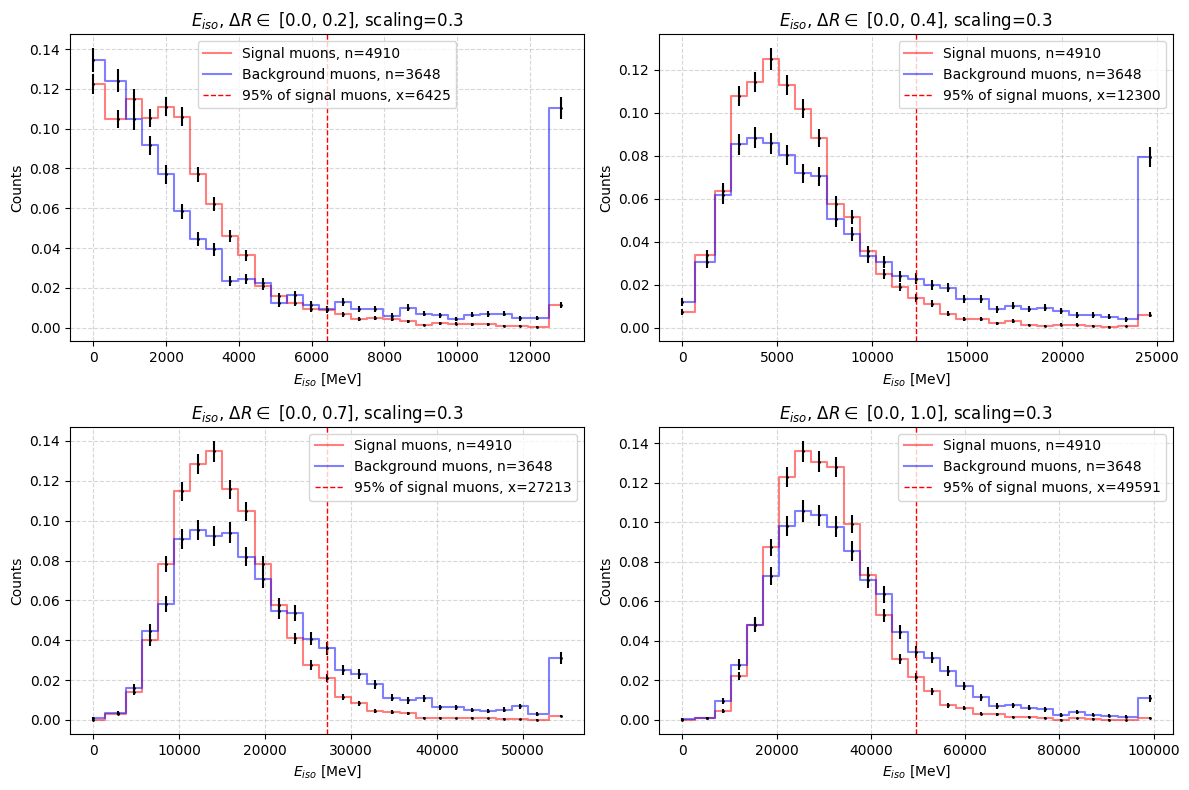

In [13]:
#####################################################################################################################################
#Empty lists
FPRs=[]
TPRs=[]
FPR95s=[]
errs=[]
######################################################################################################################################
#Steps of 100 MeV
xmin=0
xmax=20000
steps=int((xmax-xmin)/500)
bins=np.linspace(xmin, xmax, steps)
#######################################################################################################################################
#Define fundamental parameters such as dr range and scaling
dr_mins=[0.0, 0.0, 0.0, 0.0]
dr_maxs=[0.2, 0.4, 0.7, 1.0]
scaling=0.3
scaling_steps=1
step=0.0
#######################################################################################################################################


fig, axis = plt.subplots(2,2, figsize=(12, 8))
for j in range(scaling_steps):
    FPRs=[]
    TPRs=[]
    FPR95s=[]
    errs=[]
    for i in range(len(dr_mins)):
        #Get i-th parameters
        dr_min=dr_mins[i]
        dr_max=dr_maxs[i]

        #Compute i-th muon isolation
        res1=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max,
                                        event_range=[nmin1, nmax1], scaling=scaling)
        res2=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, 
                                    event_range=[0, len(ZeroBias_eta)], scaling=scaling)
        
        #Obtain the position of the percentile 95%
        zmumu_95 = np.percentile(ak.flatten(res1), 95)
        #Steps of 500 MeV
        xmin=0
        xmax=zmumu_95*2
        steps=int((xmax-xmin)/500)
        bins2=np.linspace(0, xmax, 30)
        #Obtain number of muons 
        l3=len(ak.flatten(res1))
        l4=len(ak.flatten(res2))
        row, col = divmod(i, 2)
        ax = axis[row][col]
        #Plot + get bins that will be used later for the ROC curve
        roc_bins=coolplot([res1, res2],bins2, plot_show=False, x_label=r"$E_{iso}$ [MeV]",
            y_label="Counts", title=fr"$E_{{iso}}$, $\Delta R\in$ [{dr_min}, {dr_max}], scaling={scaling}",
            labels=[rf"Signal muons, n={l3}", rf"Background muons, n={l4}"], ax=ax)
        ax.axvline(x=zmumu_95, color='r', linestyle='--', linewidth=1, label=rf"95% of signal muons, x={int(zmumu_95)}")
        ax.legend()    
    #Save figure
    filename = f"subplots_iso_dr_mins_{min(dr_mins)}_{max(dr_mins)}_dr_maxs_{min(dr_maxs)}_{max(dr_maxs)}_scaling_{scaling}.pdf"
    plt.savefig(filename)  
    plt.show() 

In [ ]:
#####################################################################################################################################
#Empty lists
FPRs=[]
TPRs=[]
FPR95s=[]
errs=[]
scalings=[]
######################################################################################################################################
#Steps of 100 MeV
xmin=0
xmax=20000
steps=int((xmax-xmin)/100)
bins=np.linspace(xmin, xmax, steps)
#######################################################################################################################################
#Define fundamental parameters such as dr range and scaling
dr_mins=[0.1]
dr_maxs=[0.3]
scaling=1.0
scaling_steps=1
step=0.25
#######################################################################################################################################

FPRs=[]
TPRs=[]
FPR95s=[]
errs=[]
for i in range(len(dr_mins)):
    #Get i-th parameters
    dr_min=dr_mins[i]
    dr_max=dr_maxs[i]

    #Compute i-th muon isolation
    res1=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max,
                                    event_range=[nmin1, nmax1], scaling=scaling)
    res2=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, 
                                event_range=[0, len(ZeroBias_eta)], scaling=scaling)

    #Obtain the position of the percentile 90%
    zmumu_95 = np.percentile(ak.flatten(res1), 95)

    #Obtain number of muons 
    l3=len(ak.flatten(res1))
    l4=len(ak.flatten(res2))

    #Plot + get bins that will be used later for the ROC curve
    roc_bins=coolplot([res1, res2],bins, plot_show=False, x_label=r"$E_{iso}$ [MeV]",
        y_label="Counts", title=fr"$E_{{iso}}$, $\Delta R\in$ [{dr_min}, {dr_max}], scaling={scaling}",
        labels=[rf"Signal muons, n={l3}", rf"Background muons, n={l4}"])
    
    #Plot vertical line located at percentile 95%
    plt.axvline(x=zmumu_95, color='r', linestyle='--', linewidth=1, label=rf"95% of signal muons, x={int(zmumu_95)}")
    plt.legend()  # Add the legend first

    #Save figure
    filename = f"iso_{dr_min}_{dr_max}_scaling_{scaling}.pdf"
    plt.savefig(filename)  
    plt.show() 

    Zmumu_counts, _ = np.histogram(ak.flatten(res1), roc_bins)
    ZeroBias_counts, _ = np.histogram(ak.flatten(res2), roc_bins)
    #Compute the cumulative sum of the counts (like integrating the histogram to the left)
    Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
    ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
    # Normalize to total events
    TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
    FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)
    #Plot ROC
    FPR95=min(FPR[TPR >= 0.95])
    err=FPR_uncertainty(FPR95, len(ak.flatten(res2)))

    FPRs.append(FPR)
    TPRs.append(TPR)
    FPR95s.append(FPR95)
    errs.append(err)
    scalings.append(scaling)
    scaling=scaling+0.25
for i in range(len(dr_mins)):
    plt.scatter(FPRs[i], TPRs[i], marker='.', 
                label=fr'$\Delta R \in$[{dr_mins[i]}, {dr_maxs[i]}], FPR value at 95% TPR={np.round(FPR95s[i],3)}$\pm${np.round(errs[i],3)},scaling={scalings[i]}')
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.plot([0,1],[0.95,0.95],color='r', linestyle='--')
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim(0.6, 1.0)
    plt.ylim(0.6, 1.0)
    plt.legend()
    plt.title(rf"Best ROC curve")
    plt.tight_layout()

filename = f"ROC_dr_min_{min(dr_mins)}_{max(dr_mins)}__dr_max_{min(dr_maxs)}_{max(dr_maxs)}_scaling_{scaling}.pdf"
plt.savefig(filename)  # Save the figure with the legend
plt.show()  # Display the figure


In [ ]:

dr_min=0.1
dr_max=0.3
#Compute the isolation and prepare it for plotting ZeroBias
res=muon_isolation_all_events(MuonTree_ZeroBias,ZeroBias_eta,ZeroBias_phi,dr_min,dr_max,[0, len(ZeroBias_pt)])
data1=ak.flatten(res)

#Compute the isolation and prepare it for plotting Z mu mu
res=muon_isolation_all_events(MuonTree_Zmumu,Zmumu_eta,Zmumu_phi,dr_min,dr_max,[nmin1,nmax1])
data2=ak.flatten(res)

# %%
#Prepare the data
ratio1=data1
ratio2=data2

e1=ak.flatten(ZeroBias_pt)
e2=ak.flatten(Zmumu_pt)


In [ ]:
#Prepare the limits
xlim=70000
ylim=6000

#Remove NaN and empty
mask1 = ~np.isnan(data1) & ~np.isnan(ratio1) & ~np.isinf(data1) & ~np.isinf(ratio1)
e1= e1[mask1]
ratio1= ratio1[mask1]
mask2 = ~np.isnan(data2) & ~np.isnan(ratio2) & ~np.isinf(data2) & ~np.isinf(ratio2)
e2= e2[mask2]
ratio2= ratio2[mask2]

# Convert Awkward arrays to NumPy
e1_np = ak.to_numpy(e1)
ratio1_np = ak.to_numpy(ratio1)
e2_np = ak.to_numpy(e2)
ratio2_np = ak.to_numpy(ratio2)

#Plot heatmaps
# Set up the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

bins = 30

# --- Zero Bias heatmap ---
h1 = axs[0].hist2d(e1_np, ratio1_np, bins=bins, range=[[10000, xlim], [0, ylim]],
                   cmap="Blues", norm=plt.cm.colors.LogNorm())

axs[0].set_xlabel("Transverse Energy [MeV]")
axs[0].set_ylabel(r"$E_{T,iso}$[MeV]")
axs[0].set_title(f"Background muons, n={len(e1_np)}")
axs[0].legend()
axs[0].grid(alpha=0.5, linestyle="--")
axs[0].set_xlim(10000, xlim)
axs[0].set_ylim(0, ylim)
fig.colorbar(h1[3], ax=axs[0], label='Counts')

# --- Z → μμ heatmap ---
h2 = axs[1].hist2d(e2_np, ratio2_np, bins=bins, range=[[10000, xlim], [0, ylim]],
                   cmap="Reds", norm=plt.cm.colors.LogNorm())

axs[1].set_xlabel("Transverse Energy [MeV]")
axs[1].set_ylabel(r"$E_{T,iso}$[MeV]")
axs[1].set_title(rf"Signal muons, n={len(e2_np)}")
axs[1].legend()
axs[1].grid(alpha=0.5, linestyle="--")
axs[1].set_xlim(10000, xlim)
axs[1].set_ylim(0, ylim)
fig.colorbar(h2[3], ax=axs[1], label='Counts')

# Adjust layout
fig.suptitle(rf"Heatmaps: $E_{{T,iso}}$ vs muon $p_T$, $\Delta R$=[{dr_min},{dr_max}]", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('heatmaps_et_iso_with0', format='pdf')
plt.show()


In [ ]:
#Prepare the limits
xlim=70000
ylim=6000

#Remove NaN and empty
mask1 = ~np.isnan(data1) & ~np.isnan(ratio1) & ~np.isinf(data1) & ~np.isinf(ratio1)
e1= e1[mask1]
ratio1= ratio1[mask1]
mask2 = ~np.isnan(data2) & ~np.isnan(ratio2) & ~np.isinf(data2) & ~np.isinf(ratio2)
e2= e2[mask2]
ratio2= ratio2[mask2]

# Convert Awkward arrays to NumPy
e1_np = ak.to_numpy(e1)
ratio1_np = ak.to_numpy(ratio1)
e2_np = ak.to_numpy(e2)
ratio2_np = ak.to_numpy(ratio2)

#Plot heatmaps
# Set up the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

bins = 30

# --- Zero Bias heatmap ---
h1 = axs[0].hist2d(e1_np, ratio1_np, bins=bins, range=[[10000, xlim], [500, ylim]],
                   cmap="Blues", norm=plt.cm.colors.LogNorm())

axs[0].set_xlabel("Transverse Energy [MeV]", fontsize=14)
axs[0].set_ylabel(r"$E_{T,iso}$ [MeV]", fontsize=14)
axs[0].set_title(f"Background muons, n={len(e1_np)}", fontsize=16)
axs[0].legend()
axs[0].grid(alpha=0.5, linestyle="--")
axs[0].set_xlim(10000, xlim)
axs[0].set_ylim(0, ylim)
fig.colorbar(h1[3], ax=axs[0], label='Counts')

# --- Z → μμ heatmap ---
h2 = axs[1].hist2d(e2_np, ratio2_np, bins=bins, range=[[10000, xlim], [500, ylim]],
                   cmap="Reds", norm=plt.cm.colors.LogNorm())

axs[1].set_xlabel("Transverse Energy [MeV]",fontsize=14)
axs[1].set_ylabel(r"$E_{T,iso}$ [MeV]", fontsize=14)
axs[1].set_title(rf"Signal muons, n={len(e2_np)}", fontsize=16)
axs[1].legend()
axs[1].grid(alpha=0.5, linestyle="--")
axs[1].set_xlim(10000, xlim)
axs[1].set_ylim(0, ylim)
fig.colorbar(h2[3], ax=axs[1], label='Counts')

# Adjust layout
fig.suptitle(rf"Heatmaps: $E_{{T,iso}}$ vs $p_T$, $\Delta R\in$[{dr_min},{dr_max}]", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('heatmaps_et_iso_without0.pdf', format='pdf')
plt.show()

In [ ]:
#Set event range
nmin1=0
nmax1=200000

Zmumu_pt1, Zmumu_eta1, Zmumu_phi1= get_all_Z_peak_pairs(MuonTree_Zmumu["muon_pt"].array()[nmin1:nmax1],MuonTree_Zmumu["muon_eta"].array()[nmin1:nmax1],MuonTree_Zmumu["muon_phi"].array()[nmin1:nmax1])[nmin1:nmax1]

In [ ]:
#Choose quality 0
Zmumu_pt=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin1:nmax1]
Zmumu_eta=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin1:nmax1]
Zmumu_phi=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin1:nmax1]
#Select the Z peak pairs
Zmumu_pt2, Zmumu_eta2, Zmumu_phi2= get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

In [ ]:
plt.figure(figsize=(6, 4))
Zmass2=invariant_mass_all_muons(Zmumu_pt2, Zmumu_eta2, Zmumu_phi2)
Zmass1=invariant_mass_all_muons(Zmumu_pt1, Zmumu_eta1, Zmumu_phi1)
Zmass2=Zmass2[~np.isnan(Zmass2)]
Zmass1=Zmass1[~np.isnan(Zmass1)]
mean1=ak.mean(Zmass1)
std1 = np.std(Zmass1, ddof=1)

mean2=ak.mean(Zmass2)
std2 = np.std(Zmass2, ddof=1)



In [ ]:
label1=f'Signal muons - Any quality \nn={len(Zmass1)}'
label2=f"Signal muons - High quality \nn={len(Zmass2)}"
coolplot([Zmass1/1000, Zmass2/1000], np.linspace(91.2-20,91.2+20,40), x_label="Invariant mass [GeV]",return_bins=False, plot_show=False, collect_overflow=False,
         labels=[label1, label2],
         title="Invariant mass histogram", y_label="Counts")
plt.axvline(91.2, linestyle='--', color='black', label="Z boson mass, x=91.2", alpha=0.7)
plt.legend()
plt.savefig('zpeak.pdf', format='pdf')
plt.show()

In [ ]:
points=5
next_dr_mins=np.linspace(0,0.3,points)
next_dr_maxs=np.linspace(1.0,3.0,points)

min_range=[min(next_dr_mins), max(next_dr_mins)]
max_range=[min(next_dr_maxs), max(next_dr_maxs)]

FPR_effs, dr_mins, dr_maxs= ROC_FPR_2D_plot(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                 ZeroBias_phi, [nmin1,nmax1], [nmin2, nmax2], min_range, max_range, points, bins=np.linspace(0,5,2000))

#Get flat position the first 5 indices of the sorted array
flat_indices = np.argsort(FPR_effs, axis=None)[:5] 
#Arrange them into 2D coordinates
positions = np.unravel_index(flat_indices, FPR_effs.shape) 
#Create list of respective pairs 
best_coords = list(zip(positions[0], positions[1]))
#Print and prepare next iteration
next_dr_mins=[]
next_dr_maxs=[]
print("Top 5 lowest FPR(90%):")
for i, (row, col) in enumerate(best_coords):
    print(fr"{i+1}. ΔR = [{dr_mins[row]}, {dr_maxs[col]}] → FPR = {FPR_effs[row, col]}")
    next_dr_mins.append(dr_mins[row])
    next_dr_maxs.append(dr_maxs[col])